In [76]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

#### 1. Data processing

In [2]:
df = pd.read_excel("data.xlsx")

In [3]:
df_copy = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99826 entries, 0 to 99825
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             99826 non-null  object 
 1   category       99826 non-null  object 
 2   title          99826 non-null  object 
 3   body           99812 non-null  object 
 4   amenities      83749 non-null  object 
 5   bathrooms      99760 non-null  object 
 6   bedrooms       99699 non-null  object 
 7   currency       99822 non-null  object 
 8   fee            99823 non-null  object 
 9   has_photo      99823 non-null  object 
 10  pets_allowed   39192 non-null  object 
 11  price          99821 non-null  float64
 12  price_display  99820 non-null  object 
 13  price_type     99823 non-null  object 
 14  square_feet    99823 non-null  object 
 15  address        7946 non-null   object 
 16  cityname       99521 non-null  object 
 17  state          99521 non-null  object 
 18  latitu

In [4]:
df_copy = df.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99826 entries, 0 to 99825
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             99826 non-null  object 
 1   category       99826 non-null  object 
 2   title          99826 non-null  object 
 3   body           99812 non-null  object 
 4   amenities      83749 non-null  object 
 5   bathrooms      99760 non-null  object 
 6   bedrooms       99699 non-null  object 
 7   currency       99822 non-null  object 
 8   fee            99823 non-null  object 
 9   has_photo      99823 non-null  object 
 10  pets_allowed   39192 non-null  object 
 11  price          99821 non-null  float64
 12  price_display  99820 non-null  object 
 13  price_type     99823 non-null  object 
 14  square_feet    99823 non-null  object 
 15  address        7946 non-null   object 
 16  cityname       99521 non-null  object 
 17  state          99521 non-null  object 
 18  latitu

In [6]:
# Drop unecessary columns:
df = df.drop(columns=["id","category","title","body","time","address","currency","price_display", "source"])

In [7]:
df.columns

Index(['amenities', 'bathrooms', 'bedrooms', 'fee', 'has_photo',
       'pets_allowed', 'price', 'price_type', 'square_feet', 'cityname',
       'state', 'latitude', 'longitude'],
      dtype='object')

In [8]:
# Fillan the 'amenities' columns with 'No amenities'
df['amenities'] =  df['amenities'].fillna("No amenities")

# Split values in the 'amenities' column:
test = set()
for value in df['amenities'].unique():
    temp = value.split(",")
    for var in temp:
        test.add(var)

# Create separate columns for each amenity: 0 = does not have that amenity, 1 = has that amenity
for column in test:
    df[column] = df['amenities'].apply(lambda x: 1 if column in x else 0)

# Drop unecessary columns after splitting and creating new columns:
df = df.drop(columns=['amenities','No','USD'])


In [9]:
# Fillan the 'pets_allowed' column
df['pets_allowed'] = df['pets_allowed'].fillna("No")
df['pets_allowed'].isna().sum()

0

In [10]:
# Drop 'NA' for all columns in the dataframe:
df = df.dropna()

In [11]:
df = df[df['bathrooms']!="Thumbnail"]
df = df[df['bedrooms']!="Thumbnail"]
df = df[df['fee'].isin(["Yes", "No"])]
df = df[df['price_type'] != 'Weekly']
df['has_photo'] = df['has_photo'].replace({"Thumbnail":"No"})
df['pets_allowed'] = df['pets_allowed'].apply(lambda x: 1 if "Cats" in x or "Dogs" in x else 0)

In [12]:
# Subset data: Apartments in "Texas", less than 2000
mask_ba = df["state"].str.contains("TX")
mask_price = df["price"] < 2000
df = df[mask_ba & mask_price]

In [13]:
class ClusteredFeatures:
    
    def __init__(self, add_constant=False):
        self.add_constant=add_constant
        self.dbscan=None
        self.result = None

    def get_coor(self, df):
        return np.radians(df[['latitude', 'longitude']])
    
    def fit_predict(self, df, eps, min_samples):
        x = self.get_coor(df)
        self.dbscan = DBSCAN(eps = eps/6371, min_samples = min_samples,  metric = 'haversine')
        self.result = self.dbscan.fit_predict(x)
    
    def transform(self, df):
        assert self.dbscan is not None, 'You have to call fit before transform!'
        
        # Cluster assignments from DBSCAN
        assignments = self.result

        # Add cluster assignment to the DataFrame
        df_with_clusters = df.copy()
        df_with_clusters['cluster'] = assignments
        
        # Optionally add constant terms (dummy variables) for each cluster
        if self.add_constant:
            for cluster_id in np.unique(assignments):
                cluster_column = np.where(assignments == cluster_id, 1, 0)
                df_with_clusters[f'cluster_{cluster_id}'] = cluster_column

        df_with_clusters = df_with_clusters.drop(columns='cluster_-1')
        return df_with_clusters
        
    def fit_transform(self, df, eps, min_samples):
        self.fit_predict(df, eps=eps, min_samples=min_samples)
        return self.transform(df)

In [14]:
df_clustered = df.copy()
cluster = ClusteredFeatures(add_constant=True)
df_clustered = cluster.fit_transform(df_clustered, eps =50, min_samples = 10)
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10759 entries, 16 to 99821
Data columns (total 53 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bathrooms           10759 non-null  object 
 1   bedrooms            10759 non-null  object 
 2   fee                 10759 non-null  object 
 3   has_photo           10759 non-null  object 
 4   pets_allowed        10759 non-null  int64  
 5   price               10759 non-null  float64
 6   price_type          10759 non-null  object 
 7   square_feet         10759 non-null  object 
 8   cityname            10759 non-null  object 
 9   state               10759 non-null  object 
 10  latitude            10759 non-null  float64
 11  longitude           10759 non-null  float64
 12  Refrigerator        10759 non-null  int64  
 13  Fireplace           10759 non-null  int64  
 14  Clubhouse           10759 non-null  int64  
 15  Parking             10759 non-null  int64  
 16  Internet

In [15]:
for column in df_clustered.columns: 
    if column in ['bathrooms','bedrooms', 'price','latitude','longitude', 'square_feet']:
        df[column] = df[column].astype('float')


In [16]:
df_clustered.columns

Index(['bathrooms', 'bedrooms', 'fee', 'has_photo', 'pets_allowed', 'price',
       'price_type', 'square_feet', 'cityname', 'state', 'latitude',
       'longitude', 'Refrigerator', 'Fireplace', 'Clubhouse', 'Parking',
       'Internet Access', 'Pool', 'Storage', 'Wood Floors', 'No amenities',
       'Gym', 'View', 'Alarm', 'Hot Tub', 'Cable or Satellite', 'Gated',
       'Playground', 'Washer Dryer', 'Dishwasher', 'Doorman', 'AC', 'Tennis',
       'Patio/Deck', 'Garbage Disposal', 'Elevator', 'Basketball', 'TV',
       'Golf', 'Luxury', 'cluster', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7',
       'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11'],
      dtype='object')

#### 2. Exploratory Data Analysis

2.1 Statistics and Distribution

In [17]:
df.describe()

,bathrooms,bedrooms,pets_allowed,price,square_feet,latitude,longitude,Refrigerator,Fireplace,Clubhouse,...,Doorman,AC,Tennis,Patio/Deck,Garbage Disposal,Elevator,Basketball,TV,Golf,Luxury
count,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,...,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000,10759.000000
mean,1.379775,1.558788,0.404499,1163.117390,880.340087,31.869706,-96.840545,0.160796,0.225207,0.231434,...,0.000651,0.124640,0.038758,0.261548,0.048796,0.024816,0.039223,0.036063,0.000186,0.001952
std,0.502294,0.684637,0.490818,320.417962,289.490144,1.541737,0.978930,0.367359,0.417738,0.421769,...,0.025500,0.330325,0.193027,0.439498,0.215452,0.155573,0.194134,0.186455,0.013634,0.044139
min,1.000000,0.000000,0.000000,300.000000,200.000000,26.159600,-106.445000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,920.000000,683.000000,30.305400,-97.103900,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1120.000000,810.000000,32.782600,-96.838700,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1375.000000,1041.000000,32.918600,-96.661500,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.500000,5.000000,1.000000,1999.000000,3475.000000,36.065600,-93.758100,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


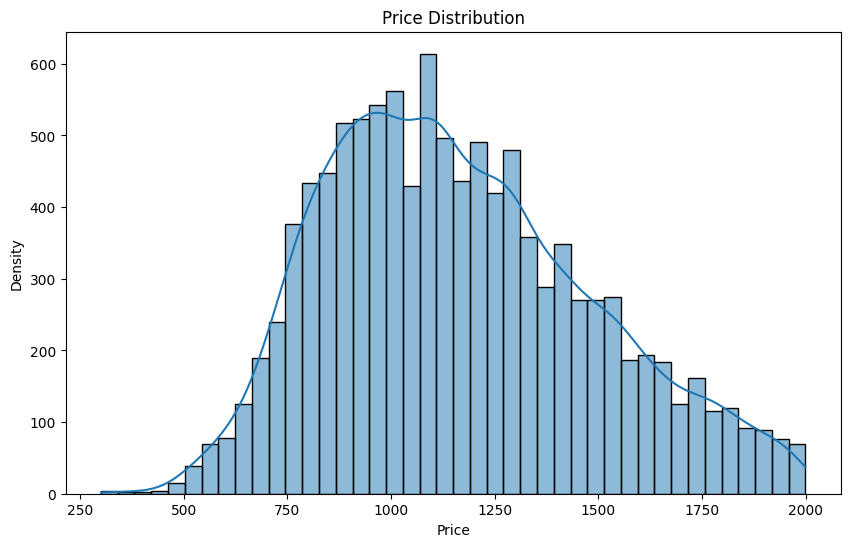

In [18]:
# Histogram of the numerical feature 'price'
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.histplot(data=df, x='price', kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

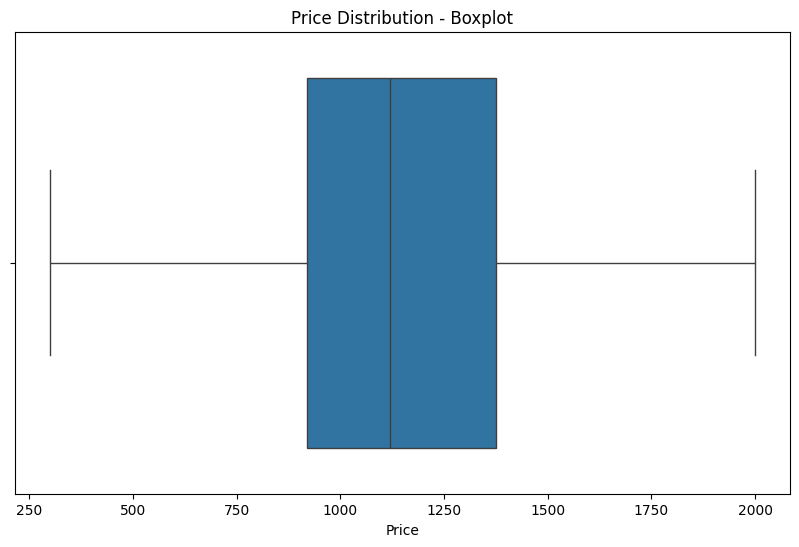

In [19]:
# Boxplot of the numerical feature 'price'
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.boxplot(data=df, x='price')
plt.title('Price Distribution - Boxplot')
plt.xlabel('Price')
plt.show()

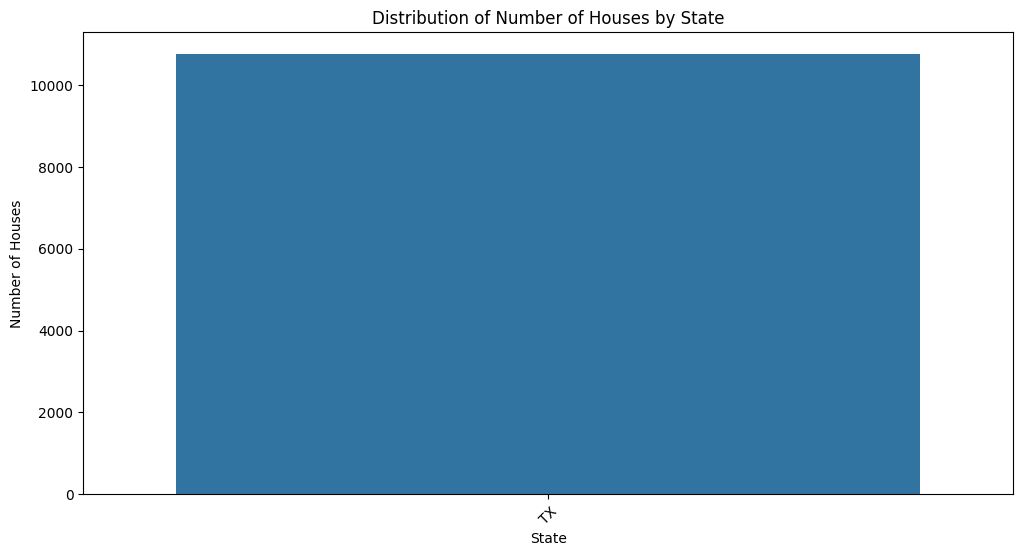

In [20]:
# Bar plot of number of houses by state
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.countplot(data=df, x='state', order=df['state'].value_counts().index)
plt.title('Distribution of Number of Houses by State')
plt.xlabel('State')
plt.ylabel('Number of Houses')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


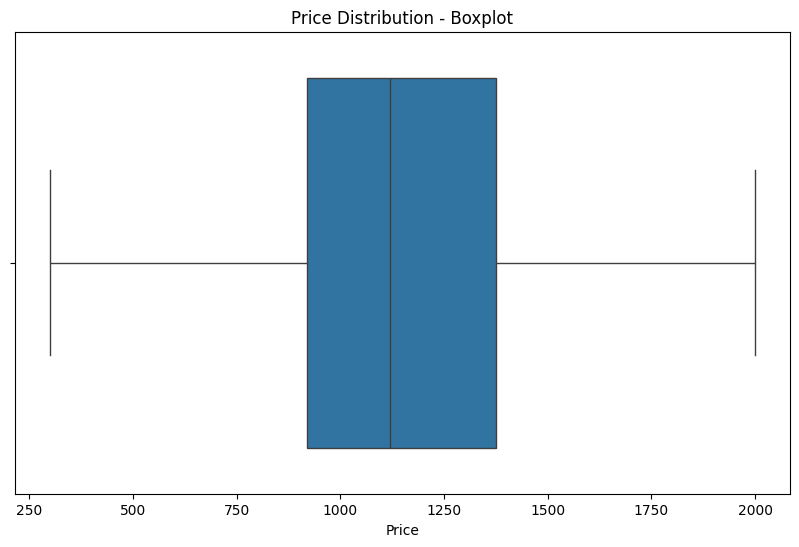

In [21]:
# Boxplot of the 'price' in CA
data_CA = df[df['state'] == 'TX']
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.boxplot(data= data_CA, x='price')
plt.title('Price Distribution - Boxplot')
plt.xlabel('Price')
plt.show()

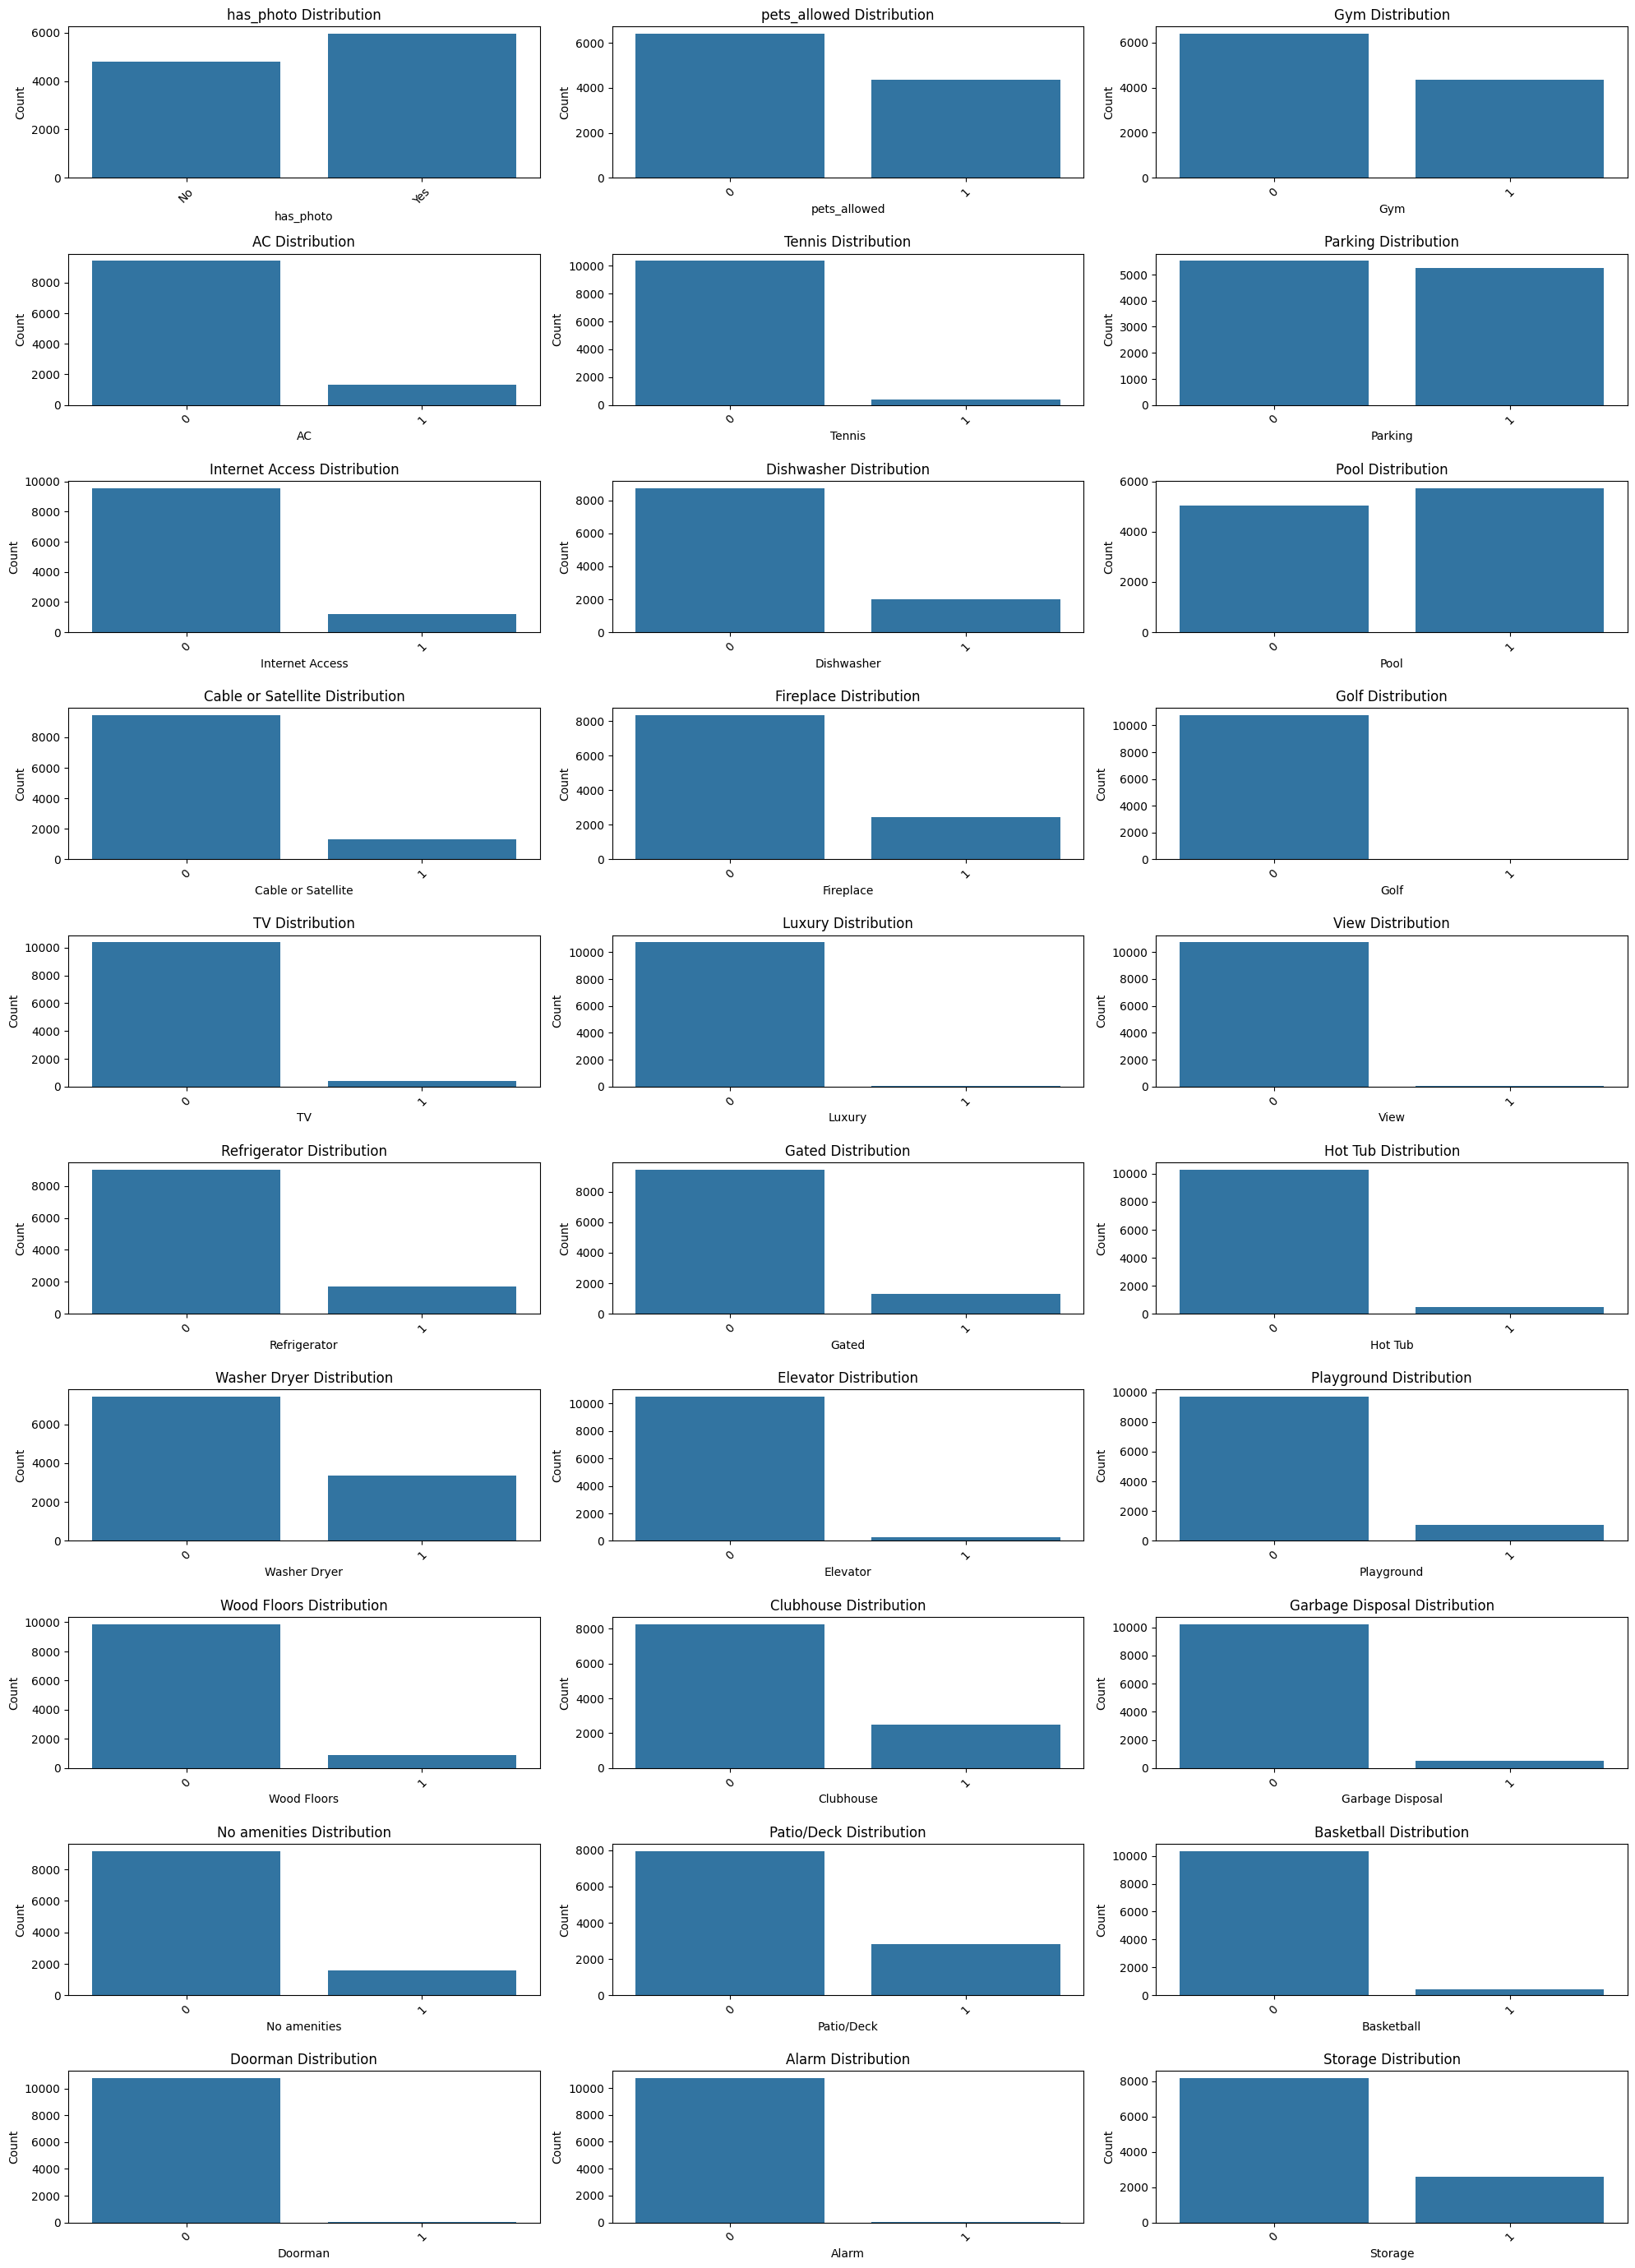

In [22]:
# Categorical columns
categorical_features = ['has_photo', 'pets_allowed', 'Gym', 'AC', 'Tennis', 'Parking',
       'Internet Access', 'Dishwasher', 'Pool', 'Cable or Satellite',
       'Fireplace', 'Golf', 'TV', 'Luxury', 'View', 'Refrigerator', 'Gated',
       'Hot Tub', 'Washer Dryer', 'Elevator', 'Playground', 'Wood Floors',
       'Clubhouse', 'Garbage Disposal', 'No amenities', 'Patio/Deck',
       'Basketball', 'Doorman', 'Alarm', 'Storage']

# Create a figure with a larger grid size
plt.figure(figsize=(20, 30))  # Adjust figure size to be large enough
total_features = len(categorical_features)

# Set up the grid size dynamically based on the number of features
for i, feature in enumerate(categorical_features, 1):
    plt.subplot((total_features // 3) + 1, 3, i)
    sns.countplot(data=df, x=feature)
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

# Ensure the layout is adjusted for all plots to fit
plt.tight_layout()
plt.show();


In [23]:
'''import plotly.express as px
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat='latitude',
    lon='longitude',
    size="price",
    center={"lat": 39.8283, "lon": -98.5795},  # Map will be centered on Helsinki
    width=1000,  # Width of map
    height=700,  # Height of map
    size_max=20,
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()'''

'import plotly.express as px\nfig = px.scatter_mapbox(\n    df,  # Our DataFrame\n    lat=\'latitude\',\n    lon=\'longitude\',\n    size="price",\n    center={"lat": 39.8283, "lon": -98.5795},  # Map will be centered on Helsinki\n    width=1000,  # Width of map\n    height=700,  # Height of map\n    size_max=20,\n)\n\nfig.update_layout(mapbox_style="open-street-map")\n\nfig.show()'

##### 2.2 Correlation heatmap

Text(0.5, 1.0, 'Correlation Heatmap')

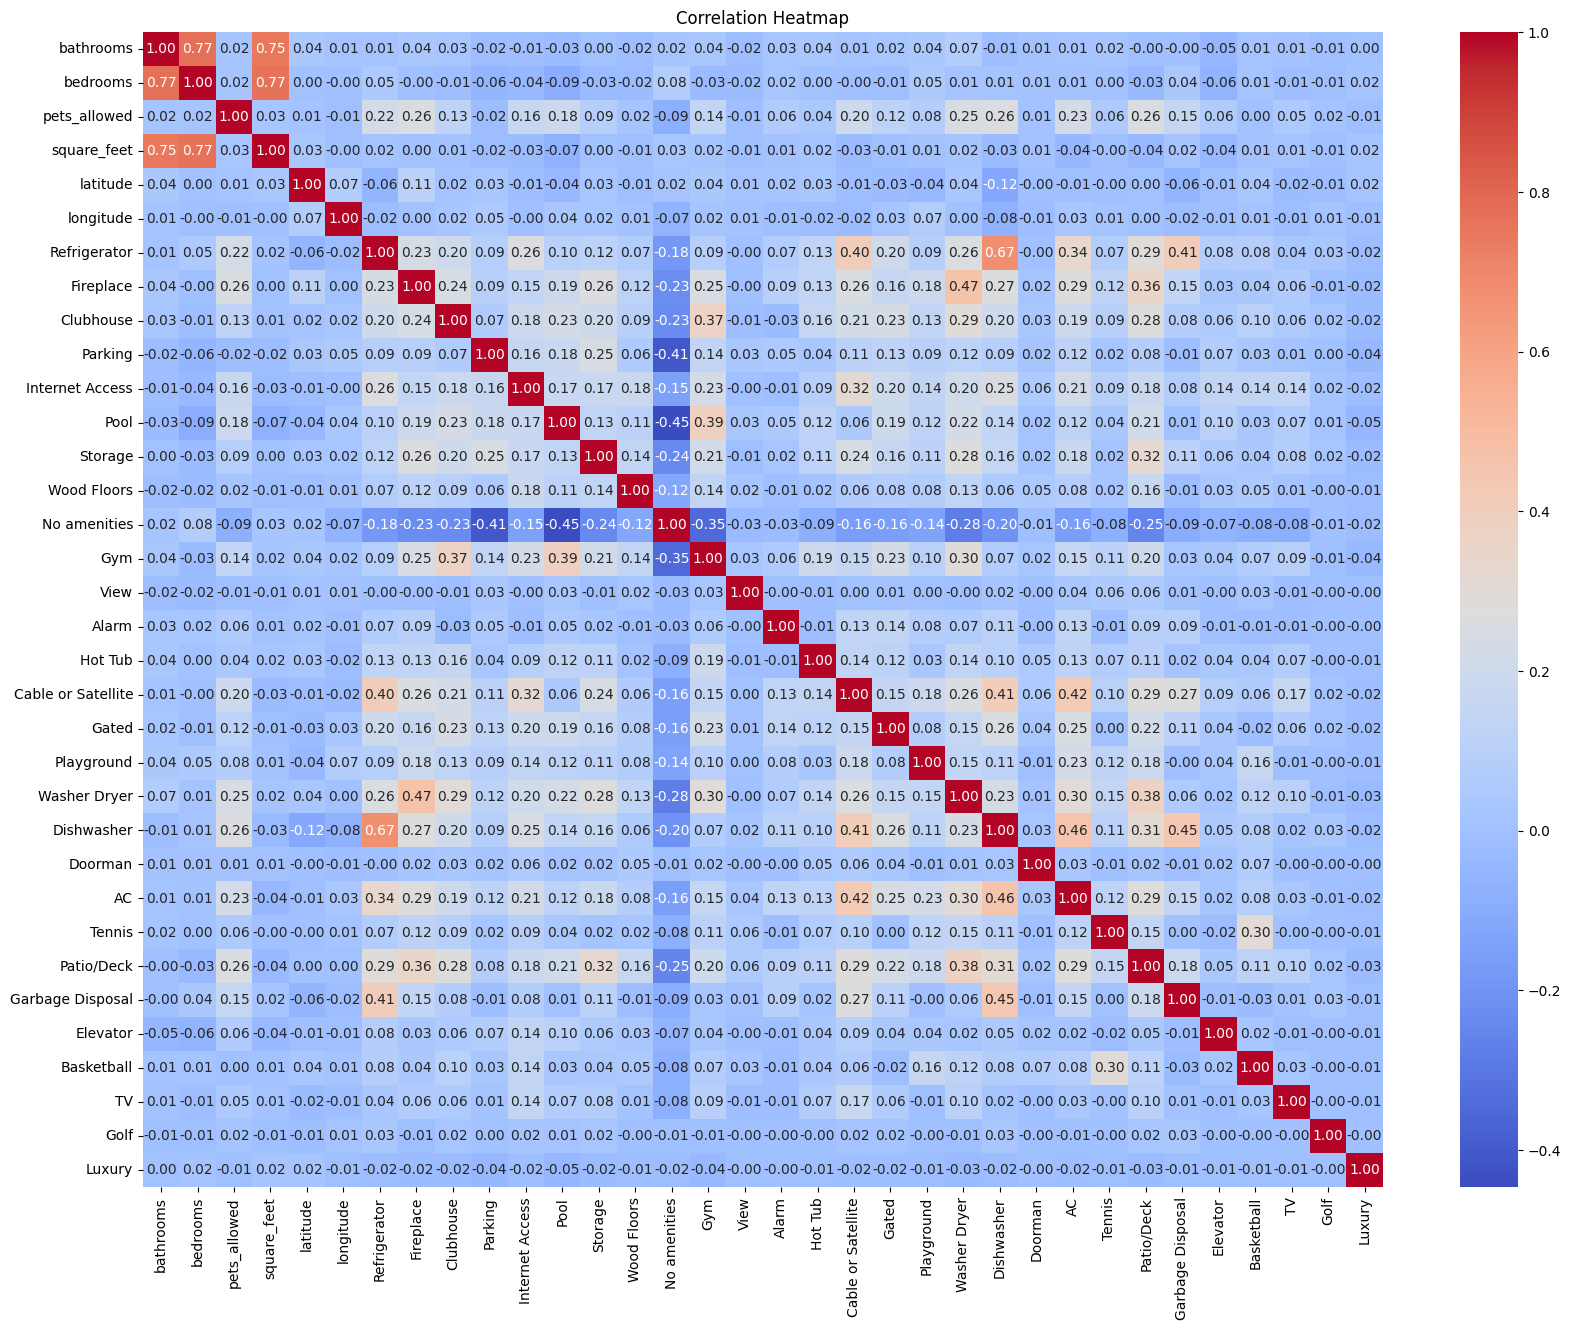

In [24]:
corr = df.select_dtypes("number").drop(columns="price").corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")

#### Test regression:

In [25]:
# Splite the model into training, test and validation set
X = df_clustered.drop(columns=['price','state','longitude','latitude','cityname']).copy()
X = pd.get_dummies(X, columns=['fee','has_photo','pets_allowed','price_type'], drop_first=True)
y = df_clustered['price'].copy()

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [26]:
Regression_comparision = {}

In [27]:
#Linear regression
lr_benchmark = LinearRegression()
lr_benchmark.fit(X_train, y_train)

y_pred = lr_benchmark.predict(X_val)

r2 = lr_benchmark.score(X_val, y_val)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)


Regression_comparision['LinearRegression_benchmark'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

In [28]:
#Ridge
ridge_benchmark = Ridge()
ridge_benchmark.fit(X_train, y_train)

y_pred = ridge_benchmark.predict(X_val)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)

Regression_comparision['Ridge_benchmark'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

In [29]:
#Lasso
lasso_benchmark = Lasso()
lasso_benchmark.fit(X_train, y_train)

y_pred = lasso_benchmark.predict(X_val)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)

Regression_comparision['Lasso_benchmark'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

In [41]:
#Decision Tree benchmark
dc_benchmark = DecisionTreeRegressor()
dc_benchmark.fit(X_train, y_train)

y_pred = dc_benchmark.predict(X_val)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)

Regression_comparision['DecisionTree_benchmark'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

In [65]:
#Random Forest benchmark
rf_benchmark = RandomForestRegressor()
rf_benchmark.fit(X_train, y_train)

y_pred = rf_benchmark.predict(X_val)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)

Regression_comparision['RandomForest_benchmark'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

In [55]:
# Randomized Grid Search parameters for Lasso
param_grid = {
        'alpha': np.linspace(0.01, 50, 200), 
        'max_iter' : [1000,2000,3000,4000,5000],
    }

rcv = RandomizedSearchCV(Lasso(), param_grid, n_iter=100)
rcv.fit(X_train, y_train)

lasso_rgs = Lasso(**rcv.best_params_)
lasso_rgs.fit(X_train, y_train)

y_pred = lasso_rgs.predict(X_val)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)

Regression_comparision['Lasso_rgs'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.682e+05, tolerance: 3.572e+04
  model = cd_fast.enet_coordinate_descent(


In [56]:
# Randomized Grid Search parameters for Ridge
param_grid = {
        'alpha': np.linspace(0.01, 50, 200), 
        'max_iter' : [1000,2000,3000,4000,5000],
    }

rcv = RandomizedSearchCV(Ridge(), param_grid, n_iter=100)
rcv.fit(X_train, y_train)

ridge_rgs = Ridge(**rcv.best_params_)
ridge_rgs.fit(X_train, y_train)

y_pred = lasso_rgs.predict(X_val)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)

Regression_comparision['Ridge_rgs'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

In [63]:
# Randomized Grid Search parameters for Decision Tree
param_grid = {
        'criterion': ["squared_error", 'friedman_mse', 'absolute_error', 'poisson'],
        'max_depth' : np.arange(1,30),
        'min_samples_split': np.arange(2, 200, step =10),
        'min_samples_leaf':np.arange(5,100, step=5)
    }

rcv = RandomizedSearchCV(DecisionTreeRegressor(), param_grid, n_iter=300)
rcv.fit(X_train, y_train)

tree_rgs = DecisionTreeRegressor(**rcv.best_params_)
tree_rgs.fit(X_train, y_train)

y_pred = tree_rgs.predict(X_val)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)

Regression_comparision['DecisionTree_rgs'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

In [74]:
# Randomized Grid Search parameters for Decision Tree
param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth' : [5,10],
        'min_samples_split': [10,30,50],
        'min_samples_leaf':[10,30,50]
    }

rcv = GridSearchCV(RandomForestRegressor(random_state=42), param_grid)
rcv.fit(X_train, y_train)

rf_rgs = RandomForestRegressor(**rcv.best_params_,random_state=42)
rf_rgs.fit(X_train, y_train)

y_pred = rf_rgs.predict(X_val)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)

Regression_comparision['RandomForest_rgs'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

In [97]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_val_scaled = scaler.transform(X_val)

#Linear regression
lr_scaler = MLPRegressor()
lr_scaler.fit(X_train_scaled, y_train)

y_pred = lr_scaler.predict(X_val_scaled)

r2 = r2_score(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)


Regression_comparision['MLP_StandardScaler'] = {'r2': r2,
                                                        'MSE': MSE,
                                                        'RMSE': RMSE,
                                                        'MAE': MAE,
                                                        'MAPE': MAPE}

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [98]:
results = pd.DataFrame(Regression_comparision)
results

,LinearRegression_benchmark,Ridge_benchmark,Lasso_benchmark,DecisionTree_benchmark,Lasso_rgs,Ridge_rgs,DecisionTree_rgs,RandomForest_benchmark,RandomForest_rgs,LinearRegression_StandardScaler,Ridge_StandardScaler,MLP_StandardScaler
r2,0.517608,0.518163,0.510163,0.361118,0.517731,0.517731,0.540997,0.639938,0.587584,0.516460,0.517668,0.457952
MSE,50553.410416,50495.147908,51333.552418,66953.112825,50540.462805,50540.462805,48102.272604,37733.514196,43220.082967,50673.715907,50547.088906,56805.133590
RMSE,224.840856,224.711255,226.569090,258.752996,224.812061,224.812061,219.322303,194.251163,207.894403,225.108232,224.826798,238.338276
MAE,174.909004,174.868605,176.362089,173.888280,174.907732,174.907732,166.943786,136.626210,158.407433,175.087539,174.922666,184.594643
MAPE,0.160433,0.160413,0.162418,0.157953,0.160432,0.160432,0.153844,0.126349,0.146794,0.160638,0.160495,0.167439
